In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option("display.max_columns", 1000)
df = pd.read_csv(r"D:\Dig\00-imarticus\Dataset\bank-additional-full.csv", sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.shape

(41188, 21)

In [4]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

<AxesSubplot:>

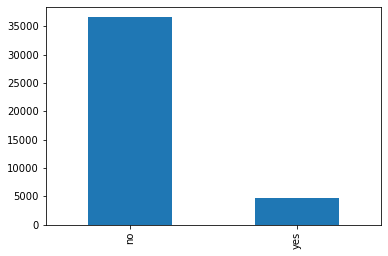

In [7]:
df['y'].value_counts().plot(kind='bar')

**OBSERVATION:**

- This is compeletely imbalanced dataset.
- We will be using **OVERSAMPLING TECHNIQUE** to balance the data.

,feature,f,p
7,month,372.537812,0.000000e+00
9,poutcome,2357.224309,0.000000e+00
0,job,89.447741,1.618353e-201
6,contact,881.707070,9.856509e-192
3,default,205.300526,1.908249e-89
2,education,27.711120,2.682772e-38
1,marital,41.003185,1.898385e-26
8,day_of_week,6.539592,2.950575e-05
4,housing,2.842433,5.829511e-02
5,loan,0.546988,5.786941e-01


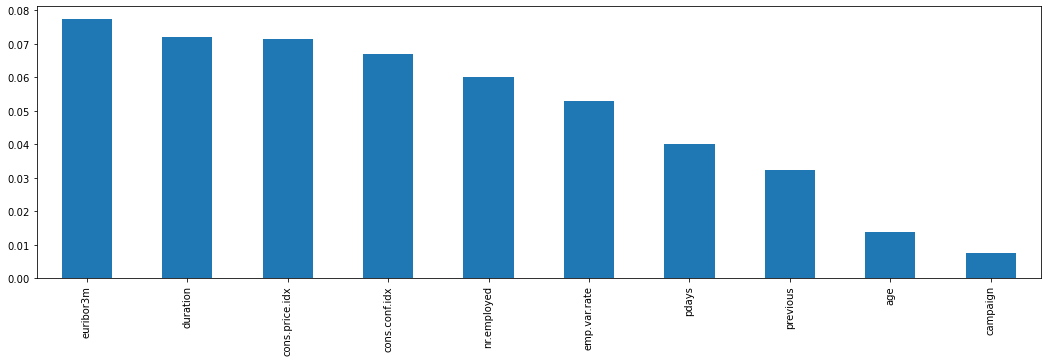

In [8]:
# Applying Statistical Tests


df['y'] = df['y'].map({'no':0, 'yes':1})

from scipy import stats

class stats_test:
    def __init__(self,data):
        self.data = data
        
    # ------------------------ FUNCTION 1: ANALYSIS OF VARIANCE (ANOVA)------------------------------------
    def Anova(self):
        categorical_features = self.data.select_dtypes(exclude=[np.number]).columns
        self.data[categorical_features] = self.data[categorical_features].fillna('missing')
        
        # Making the ANOVA
        anova = {'feature':[], "f":[], "p":[]}
        for i in self.data[categorical_features]:
            group_prices = []
            
            for group in self.data[i].unique():
                group_prices.append(self.data[self.data[i] == group]['y'].values)
                
            f, p = stats.f_oneway(*group_prices)
            anova['feature'].append(i)
            anova['f'].append(f)
            anova['p'].append(p)
            
        anova = pd.DataFrame(anova)
        anova = anova[["feature","f","p"]]
        anova.sort_values("p", inplace = True)
        

        return anova
    
    
    # ---------------------- FUNCTION 2: MUTUAL-INFORMATION --------------------------------------------------
    def mutual_info(self):
        # Choosing the numerical feature
        numerical_feature = list(self.data.select_dtypes(include = [np.number]).columns)
        data = self.data[numerical_feature]
        
        
        # Splitting the numerical dataset into train and test
        from sklearn.model_selection import train_test_split
        
        x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,:-1],
                                                            data.iloc[:,-1],
                                                            test_size = 0.3,
                                                            random_state = 0)
    
        from sklearn.feature_selection import mutual_info_regression
        from sklearn.feature_selection import SelectPercentile
    
    
        mi = mutual_info_regression(x_train.fillna(0), y_train)
        mi = pd.Series(mi)
        mi.index = x_train.columns
        mi = mi.sort_values(ascending = False)

        # Plotting the Bar-plot of the dataset
        mi.sort_values(ascending = False).plot.bar(figsize = (18,5))
    
        # Selecting the best Numeric-Features
        features = SelectPercentile(mutual_info_regression, 
                                percentile = 10).fit(x_train.fillna(0), y_train)
    
        # Returning the Support of the columns of the x_train
        return x_train.columns[features.get_support()]
   
    #-----------------------------------------------------------------------------------------#
    
# Accessing the Class + method
sts = stats_test(df)
sts.mutual_info()
sts.Anova()

In [9]:
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


# Getting All the cactegorical Values

In [10]:
categorical_features = df.select_dtypes(exclude=[np.number]).columns
categorical_features

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [11]:
for i in df[categorical_features]:
    print(df[i].value_counts())
    print('-'*80)

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
--------------------------------------------------------------------------------
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
--------------------------------------------------------------------------------
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
--------------------------------------------------------------------------------
no         32588
unknown     8597
yes            3
Name: default, dtype: int64
----------------

In [12]:
from sklearn.preprocessing import LabelEncoder

df['contact'] = df['contact'].map({'cellular':1, 'telephone':0})

# ----------------------------------------------------------------------------------

label_encoding_data = ['poutcome', 'education']

def labelEncodingData(data, feature):
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])
    
for i in df[label_encoding_data]:
    labelEncodingData(df, i)
    

In [13]:
print(df.shape)
df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,0,no,no,no,0,may,mon,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,3,unknown,no,no,0,may,mon,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,3,no,yes,no,0,may,mon,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,1,no,no,no,0,may,mon,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,3,no,no,yes,0,may,mon,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [14]:
df.contact.value_counts()

1    26144
0    15044
Name: contact, dtype: int64

In [15]:
one_hot_encoding_data = ['loan', 'default', 'housing']

df1=pd.get_dummies(df[one_hot_encoding_data], drop_first=True)

df = pd.concat([df1, df],axis=1)
df.drop(one_hot_encoding_data, axis=1, inplace=True)

print(df.shape)
df.head()

(41188, 24)


,loan_unknown,loan_yes,default_unknown,default_yes,housing_unknown,housing_yes,age,job,marital,education,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0,0,0,0,0,0,56,housemaid,married,0,0,may,mon,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,0,0,1,0,0,0,57,services,married,3,0,may,mon,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,0,0,0,0,0,1,37,services,married,3,0,may,mon,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,0,0,0,0,0,0,40,admin.,married,1,0,may,mon,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,0,1,0,0,0,0,56,services,married,3,0,may,mon,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [16]:
count_encoding_data = ['day_of_week', 'month', 'marital', 'job','education']

def freqEncoding(data, feature):
    myfeature = data[feature].value_counts().to_dict()
    data[feature] = data[feature].map(myfeature)
    
    
for i in df[count_encoding_data]:
    freqEncoding(df, i)

print(df.shape)
df.head()

(41188, 24)


,loan_unknown,loan_yes,default_unknown,default_yes,housing_unknown,housing_yes,age,job,marital,education,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0,0,0,0,0,0,56,1060,24928,4176,0,13769,8514,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,0,0,1,0,0,0,57,3969,24928,9515,0,13769,8514,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,0,0,0,0,0,1,37,3969,24928,9515,0,13769,8514,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,0,0,0,0,0,0,40,10422,24928,2292,0,13769,8514,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,0,1,0,0,0,0,56,3969,24928,9515,0,13769,8514,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


# Apply Over-Sampling on our imbalanced dataset

In [17]:
X = df.drop('y', axis=1)
y = df['y']

no = df[df['y']==0]
yes = df[df['y']==1]

print(no.shape, yes.shape)

(36548, 24) (4640, 24)


In [19]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = 'minority')

X_sm, y_sm = sm.fit_resample(X,y)

In [20]:
y_sm.value_counts()

0    36548
1    36548
Name: y, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, stratify=y_sm)

print(X_train.shape, X_test.shape)

(58476, 23) (14620, 23)


In [25]:
y_train.value_counts()

0    29238
1    29238
Name: y, dtype: int64

In [26]:
y_test.value_counts()

0    7310
1    7310
Name: y, dtype: int64

# Creating Model

In [28]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train,y_train)

SVC()

In [29]:
y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix

print("Accuracy Score:",accuracy_score(y_test, y_pred))

Accuracy Score: 0.8503419972640219


In [30]:
confusion_matrix(y_test, y_pred)

array([[6241, 1069],
       [1119, 6191]], dtype=int64)

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      7310
           1       0.85      0.85      0.85      7310

    accuracy                           0.85     14620
   macro avg       0.85      0.85      0.85     14620
weighted avg       0.85      0.85      0.85     14620

